In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

In [72]:
#code to import directly from kaggle into collab
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d yasserhessein/gender-dataset --unzip -p /content/dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/yasserhessein/gender-dataset
License(s): unknown
100% 1.32G/1.32G [00:45<00:00, 33.7MB/s]
100% 1.32G/1.32G [00:45<00:00, 31.3MB/s]


In [73]:
image=cv2.imread('/content/dataset/Dataset/Test/Male/160002.jpg')
print(image.shape)

(218, 178, 3)


In [74]:
import os
import random


original_dataset_dir = '/content/dataset/Dataset'
reduced_dataset_dir = '/content/reduced_dataset'


images_per_class = {
    'Train': 1000,
    'Test': 200,
    'Validation': 1000

# Create the reduced dataset directory
os.makedirs(reduced_dataset_dir, exist_ok=True)

for split in ['Train', 'Test', 'Validation']:
    split_dir = os.path.join(original_dataset_dir, split)
    reduced_split_dir = os.path.join(reduced_dataset_dir, split)

    # Create directories for each split
    os.makedirs(reduced_split_dir, exist_ok=True)

    for class_name in ['Male', 'Female']:
        class_dir = os.path.join(split_dir, class_name)
        reduced_class_dir = os.path.join(reduced_split_dir, class_name)

        # Create directories for each class
        os.makedirs(reduced_class_dir, exist_ok=True)

        # Get all image filenames in the class directory
        all_images = [f for f in os.listdir(class_dir) if f.endswith(('jpg', 'png', 'jpeg'))]

        # Randomly sample the specified number of images
        sampled_images = random.sample(all_images, min(images_per_class[split], len(all_images)))

        # Move the sampled images to the reduced dataset directory
        for img_name in sampled_images:
            src_path = os.path.join(class_dir, img_name)
            dest_path = os.path.join(reduced_class_dir, img_name)
            os.rename(src_path, dest_path)  # Move the file

        print(f"Reduced {split}/{class_name}: {len(sampled_images)} images moved.")


Reduced Train/Male: 1000 images moved.
Reduced Train/Female: 1000 images moved.
Reduced Test/Male: 200 images moved.
Reduced Test/Female: 200 images moved.
Reduced Validation/Male: 1000 images moved.
Reduced Validation/Female: 1000 images moved.


In [75]:
import glob
import random
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array


img_dims = (109, 89, 3)


data = []
labels = []

# Load image file paths using glob
image_dir = '/content/reduced_dataset/Train'
image_files = glob.glob(os.path.join(image_dir, '**', '*.*'), recursive=True)  # Recursive search for images

#shuffling the images so that the model doesn't get initially traa
random.shuffle(image_files)

# Converting images to arrays and labeling the categories
for img_path in image_files:
    # Load and preprocess image
    image = cv2.imread(img_path)
    if image is None:  # Handle unreadable files
        print(f"Could not read image: {img_path}")
        continue

    image = cv2.resize(image, (img_dims[0], img_dims[1]))  # Resize image
    image = img_to_array(image)  # Convert to array
    data.append(image)

    # Label assignment based on folder structure
    label = os.path.basename(os.path.dirname(img_path))  # Extract folder name
    label = 1 if label.lower() == "female" else 0  # Adjust based on folder names
    labels.append(label)

# Convert data and labels to NumPy arrays
data = np.array(data, dtype="float32") / 255.0  # Normalize pixel values
labels = np.array(labels, dtype="int")

# Print results
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")


Data shape: (2000, 89, 109, 3)
Labels shape: (2000,)


In [76]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
# split dataset for training and validation
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

trainY = to_categorical(trainY, num_classes=2) # [[1, 0], [0, 1], [0, 1], ...]
testY = to_categorical(testY, num_classes=2)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

aug = ImageDataGenerator(rotation_range=25,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode="nearest")

(1600, 89, 109, 3)
(1600, 2)
(400, 89, 109, 3)
(400, 2)


In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import os
import glob


In [273]:
model = Sequential([
    # First Conv Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(89, 109, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Second Conv Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Third Conv Layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    # Flatten and fully connected layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout for regularization

    # Output Layer for binary classification (single neuron with sigmoid)
    Dense(2, activation='sigmoid')  # Output layer with sigmoid for binary classification
])

In [274]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])


# Train the model
H = model.fit(
    trainX, trainY,
    validation_data=(testX, testY),
    batch_size=batch_size,
    epochs=20
)



Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 725ms/step - accuracy: 0.6728 - loss: 0.9901 - val_accuracy: 0.5300 - val_loss: 0.6636
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 764ms/step - accuracy: 0.8877 - loss: 0.2896 - val_accuracy: 0.7125 - val_loss: 0.5621
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 731ms/step - accuracy: 0.9187 - loss: 0.2332 - val_accuracy: 0.5975 - val_loss: 0.6351
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 722ms/step - accuracy: 0.9483 - loss: 0.1422 - val_accuracy: 0.5350 - val_loss: 1.1816
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 715ms/step - accuracy: 0.9585 - loss: 0.1156 - val_accuracy: 0.8175 - val_loss: 0.3697
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 702ms/step - accuracy: 0.9700 - loss: 0.0876 - val_accuracy: 0.8775 - val_loss: 0.3311
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 760ms/step - accuracy: 0.9820 - loss: 0.0514 - val_accuracy: 0.8600 - val_loss: 0.3571
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 777ms/step - accuracy: 0.9887 - loss: 0.0410 - val_accu

In [275]:
results = model.evaluate(testX, testY)
print("Loss =", results[0])
print("Accuracy =", results[1] * 100, "%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.9462 - loss: 0.2158
Loss = 0.3045811355113983
Accuracy = 92.25000143051147 %


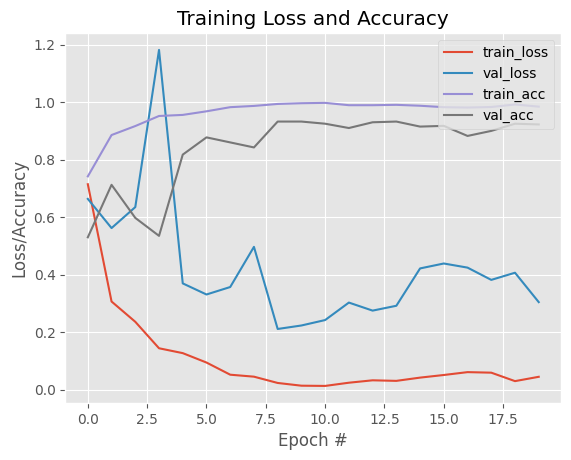

In [277]:
plt.style.use("ggplot")
plt.figure()
N = 20
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")

plt.savefig('plot.png')
plt.show()


In [278]:
# Save the model with .h5 extension
model.save('gender_detection.h5')

print("Model saved successfully.")


Model saved successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


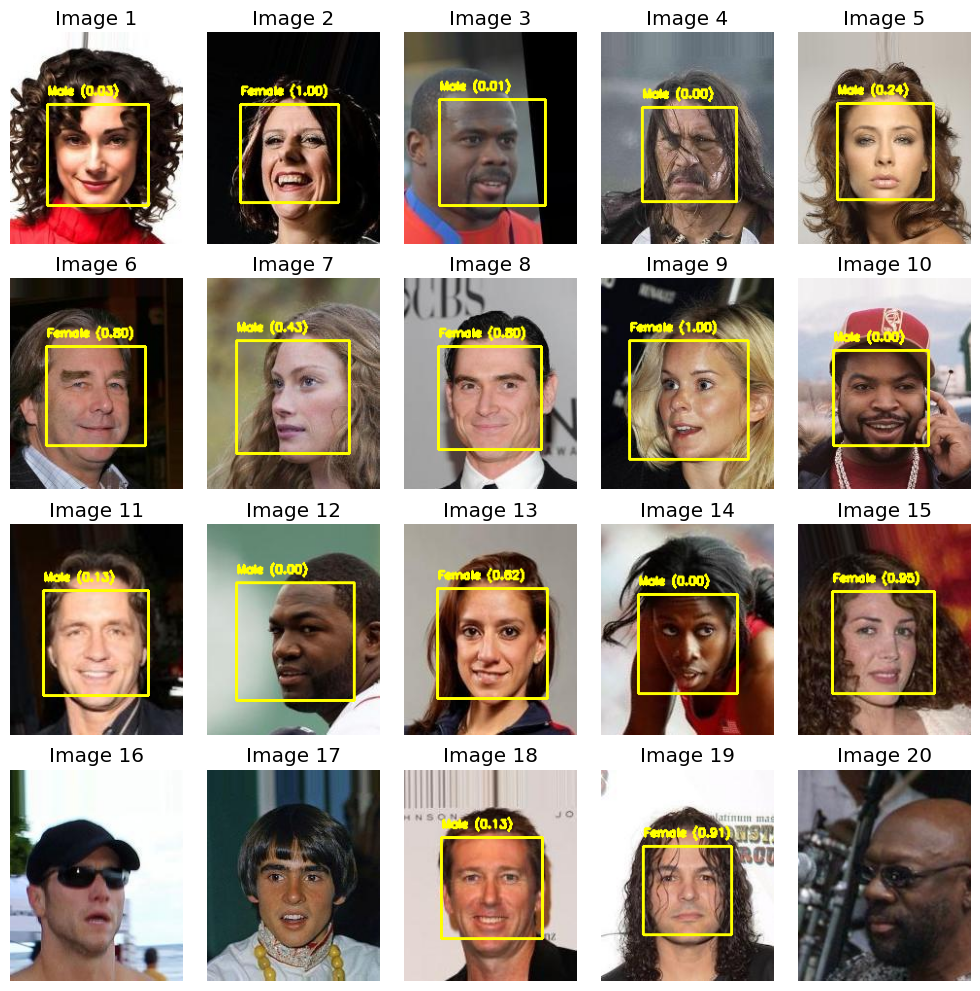

In [279]:
import os
import random
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('gender_detection.h5')

# Load the dataset directory
image_dir = '/content/dataset/Dataset/Test'
image_files = glob.glob(os.path.join(image_dir, '**', '*.*'), recursive=True)  # Recursive search for images

# Shuffle the image files for randomness
random.shuffle(image_files)

# Load the face detection model from OpenCV (Haar Cascade or DNN)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces and predict gender
def predict_gender_and_display(image_path, model):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        roi = image[y:y+h, x:x+w]
        roi = cv2.resize(roi, (img_dims[0], img_dims[1]))
        roi = img_to_array(roi) / 255.0  # Normalize and convert to array

        roi = np.expand_dims(roi, axis=0)  # Add batch dimension
        prediction = model.predict(roi)
        gender_label = 'Female' if prediction[0][1] > 0.5 else 'Male'

        # Draw rectangle and label on the image
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 255), 2)  # Yellow rectangle
        cv2.putText(image, f"{gender_label} ({prediction[0][1]:.2f})", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 2)

        # Annotate the image with bounding box and prediction
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, gender_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)

    return image

# Display 20 images
num_images_to_show = 20

plt.figure(figsize=(10, 10))
for i in range(num_images_to_show):
    image_path = image_files[i]
    result_image = predict_gender_and_display(image_path, model)

    plt.subplot(4, 5, i + 1)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [280]:
from sklearn.metrics import confusion_matrix, classification_report

# Predict on test set
predictions = model.predict(testX)

# Convert predictions to classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(testY, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(true_classes, predicted_classes))
print(classification_report(true_classes, predicted_classes))


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step
[[191  16]
 [ 15 178]]
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       207
           1       0.92      0.92      0.92       193

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


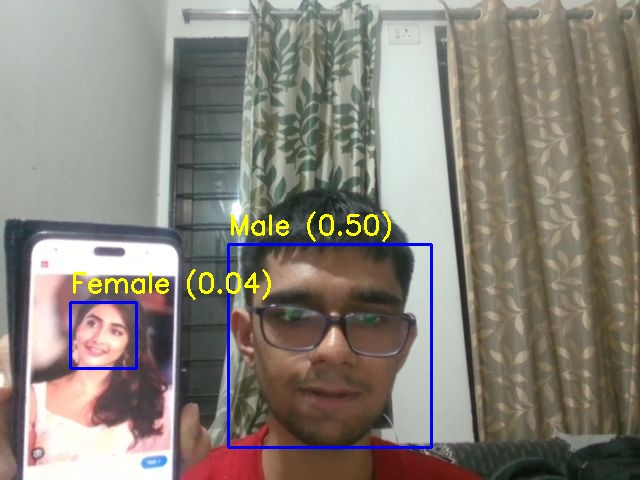

In [317]:
import cv2
import numpy as np
from keras.models import load_model
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

# Load the pre-trained model
model = load_model('gender_detection.h5')  # Replace with your model file

# Load Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def take_photo(filename='photo.jpg', quality=0.8):
    """Takes a photo using the Google Colab environment."""
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = 'Capture';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});

        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for Capture to be clicked.
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getVideoTracks()[0].stop();
        div.remove();
        return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def gender_detection(filename):
    """Detects gender in the captured image."""
    # Read the captured image
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    if len(faces) == 0:
        print("No faces detected.")
        return

    for (x, y, w, h) in faces:
        # Extract the face region
        face = gray[y:y+h, x:x+w]

        # Convert grayscale face region to RGB
        face_rgb = cv2.cvtColor(face, cv2.COLOR_GRAY2RGB)

        # Resize to match the model's input size
        face_resized = cv2.resize(face_rgb, (89, 109))

        # Normalize pixel values to [0, 1]
        face_normalized = face_resized / 255.0

        # Add batch dimension
        face_reshaped = np.expand_dims(face_normalized, axis=0)

        # Predict gender
        prediction = model.predict(face_reshaped)
        gender = "Male" if prediction[0][1] > 0.5 else "Female"


        # Annotate the image with bounding box and prediction
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, f"{gender} ({prediction[0][1]:.2f})", (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)


    # Save and display the result
    result_filename = "result.jpg"
    cv2.imwrite(result_filename, img)
    display(Image(result_filename))

try:
    # Capture a photo
    filename = take_photo()

    # Perform gender detection
    gender_detection(filename)
except Exception as err:
    print(f"Error: {err}")
